In [1]:
# # Install tensorflow, instruction below should do that. Be sure that you are in your intended virtual environment
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### I have used content from [Link](https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/classification_iris_data_with_keras.ipynb#scrollTo=2xnX-NTsFQQa)

to understand how to use TPU to run tf keras models

In [18]:
import numpy as np
import tensorflow as tf
import os

In [17]:
print(tf.__version__)
import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/classification_iris_data_with_keras.ipynb')

2.12.0


<ipython-input-17-821088d430d8>:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(tf.__version__) < '1.14':


In [19]:
use_tpu = True

if use_tpu:
    assert "COLAB_TPU_ADDR" in os.environ, "Missing TPU; did you request a TPU in Notebook Settings?"

if "COLAB_TPU_ADDR" in os.environ:
  TF_MASTER = "grpc://{}".format(os.environ["COLAB_TPU_ADDR"])
else:
  TF_MASTER=""

In [20]:
# TPU address
tpu_address = TF_MASTER

In [21]:
tpu_address

'grpc://10.80.220.34:8470'

In [3]:
# Useful pieces
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Sequential = tf.keras.models.Sequential
Embedding = tf.keras.layers.Embedding
SimpleRNN = tf.keras.layers.SimpleRNN
Dense = tf.keras.layers.Dense
LSTM = tf.keras.layers.LSTM
Dropout = tf.keras.layers.Dropout

In [4]:
# Load in data from data.py
from data import text_data_arr

In [5]:
# Tokenize the text at the character level
tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=True,
    oov_token=None,
    analyzer=None
)

In [226]:
# Convert text to sequences (use the tokenizer)
tokenizer.fit_on_texts(text_data_arr)
sequences = tokenizer.texts_to_sequences(text_data_arr)

In [227]:
# Prepare input and output (target) sequences
input_sequences = []
output_sequences = []
sequence_length = 100

for seq in sequences:
  curr_seq_len = len(seq)
  for i in range(curr_seq_len - sequence_length):
    start = i
    end = start + sequence_length
    input_sequences.append(seq[start: end])
    output_sequences.append(seq[end])

input_sequences = tf.convert_to_tensor(pad_sequences(input_sequences, maxlen=sequence_length))
output_sequences = tf.convert_to_tensor(output_sequences, dtype=tf.int32)

In [228]:
assert isinstance(input_sequences, tf.Tensor)
assert isinstance(output_sequences, tf.Tensor)
assert len(input_sequences) == len(output_sequences)

In [229]:
len(input_sequences)

23180

In [230]:
# set vocab_size based on tokenizer
vocab_size = len(tokenizer.word_index) + 1 # +1 for padding

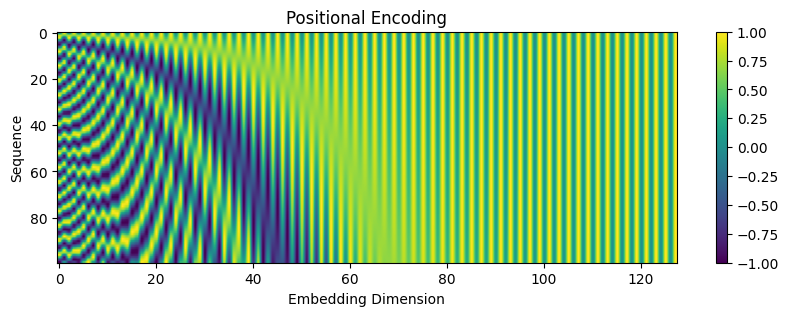

In [250]:
import matplotlib.pyplot as plt


def get_angles(positions, i_s, emb_model):
        angles = np.exp((i_s / emb_model) * -np.log(10000.))
        return positions * angles


def positional_encoding(sequence_length, emb_model):
   pe = np.zeros((1, sequence_length, emb_model))
   positions = np.arange(sequence_length)
   angle_rads = get_angles(
      positions[:, np.newaxis],
      np.arange(0, emb_model, 2),
      emb_model
    )
   pe[:, :, 0::2] = np.sin(angle_rads)
   pe[:, :, 1::2] = np.cos(angle_rads)
   pe = tf.convert_to_tensor(pe, dtype=tf.float32)
   return pe

d_model = 128

pos_enc = positional_encoding(sequence_length, d_model)
pos_enc = pos_enc[0]  # Remove the batch dimension

plt.figure(figsize=(10, 3))
plt.imshow(pos_enc, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence")
plt.title("Positional Encoding")
plt.show()

In [232]:
def causal_attn_mask(batch_size, seq_len):
  i = tf.range(seq_len)[:, tf.newaxis]
  j = tf.range(seq_len)
  mask = i >= j
  mask = tf.cast(mask, tf.bool)
  mask = mask[tf.newaxis, :, :]
  # ref of below line from here: https://keras.io/examples/generative/text_generation_with_miniature_gpt/
  mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)
  return tf.tile(mask, mult)


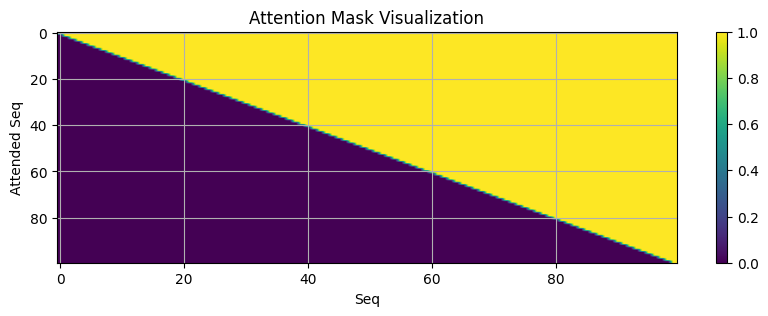

In [233]:
mask_test = tf.transpose(causal_attn_mask(32, 100)[0])

plt.figure(figsize=(10, 3))
plt.imshow(mask_test, cmap="viridis", aspect="auto")
plt.colorbar()
plt.xlabel("Seq")
plt.ylabel("Attended Seq")
plt.title("Attention Mask Visualization")
plt.grid()
plt.show()

In [234]:
class TransformerBlock(tf.keras.layers.Layer):
  def __init__(
      self,
      embed_dim,
      num_heads,
      ff_dim,
      attn_dropout_rate=0.3,
      ff_dropout_rate=0.3,
      add_pe=False,
      get_last=False,
      **kwargs
    ):
     super(TransformerBlock, self).__init__()
     self.add_pe = add_pe
     self.get_last = get_last

     self.mha = tf.keras.layers.MultiHeadAttention(num_heads, embed_dim)
     self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
     self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
     self.attn_dropout = tf.keras.layers.Dropout(rate=attn_dropout_rate)
     self.ff_dropout = tf.keras.layers.Dropout(rate=ff_dropout_rate)
     self.ff = Dense(units=ff_dim, activation="relu")

  def call(self, inputs):
    _, seq_len, embed_dim = inputs.shape
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]

    if self.add_pe:
      inputs += positional_encoding(sequence_length=seq_len, emb_model=embed_dim)

    attn_mask = causal_attn_mask(batch_size, seq_len)
    attn_out = self.mha(inputs, inputs, attention_mask=attn_mask)
    attn_out = self.layernorm1(attn_out + inputs)
    attn_out = self.attn_dropout(attn_out)

    ff_out = self.ff(attn_out)
    ff_out = self.layernorm2(ff_out + attn_out)
    ff_out = self.ff_dropout(ff_out)

    if self.get_last:
      ff_out = ff_out[:, -1, :]

    return ff_out


In [243]:
# Define the model architecture - 4 layers as described below
def create_model():
  return Sequential([
      # Embedding size of 32
      Embedding(input_length=sequence_length, input_dim=vocab_size, output_dim=128),
      # Transformer Block 1
      TransformerBlock(embed_dim=128, num_heads=8, ff_dim=128, add_pe=True),
      # Transformer Block 2
      TransformerBlock(embed_dim=128, num_heads=8, ff_dim=128, add_pe=False, get_last=True),
      # MLP
      # Dense Layer - dependent on vocab_size, activation is softmax
      Dense(units=vocab_size, activation="softmax"),
  ])

In [223]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [244]:
with strategy.scope():
  model = create_model()
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 100, 128)          5120      
                                                                 
 transformer_block_74 (Trans  (None, 100, 128)         544512    
 formerBlock)                                                    
                                                                 
 transformer_block_75 (Trans  (None, 128)              544512    
 formerBlock)                                                    
                                                                 
 dense_191 (Dense)           (None, 40)                5160      
                                                                 
Total params: 1,099,304
Trainable params: 1,099,304
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 embedding (Embedding)       (None, 100, 32)           1280

 lstm (LSTM)                 (None, 100, 128)          82432

 lstm_1 (LSTM)               (None, 128)               131584

 dense (Dense)               (None, 40)                5160

=================================================================
Total params: 220,456
Trainable params: 220,456
Non-trainable params: 0
_________________________________________________________________

In [245]:
# Train the model
epochs = 100  # Increase the number of epochs to give the model more time to learn
batch_size = 128

model.fit(input_sequences, output_sequences, epochs=epochs, batch_size=batch_size)

Epoch 1/100
182/182 [==============================] - 16s 32ms/step - loss: 3.2746 - accuracy: 0.1385
Epoch 2/100
182/182 [==============================] - 3s 17ms/step - loss: 3.0792 - accuracy: 0.1773
Epoch 3/100
182/182 [==============================] - 4s 20ms/step - loss: 3.0447 - accuracy: 0.1831
Epoch 4/100
182/182 [==============================] - 3s 18ms/step - loss: 3.0299 - accuracy: 0.1844
Epoch 5/100
182/182 [==============================] - 3s 18ms/step - loss: 3.0261 - accuracy: 0.1845
Epoch 6/100
182/182 [==============================] - 3s 18ms/step - loss: 3.0291 - accuracy: 0.1840
Epoch 7/100
182/182 [==============================] - 4s 19ms/step - loss: 2.9669 - accuracy: 0.1920
Epoch 8/100
182/182 [==============================] - 3s 18ms/step - loss: 2.8113 - accuracy: 0.2093
Epoch 9/100
182/182 [==============================] - 3s 18ms/step - loss: 2.6917 - accuracy: 0.2419
Epoch 10/100
182/182 [==============================] - 3s 17ms/step - loss: 2.62

In [246]:
model.save_weights("model_weights.h5")

In [247]:
# Genereate Text
def generate_text(seed_text, model, tokenizer, sequence_length, num_chars_to_generate):
    generated_text = seed_text
    for _ in range(num_chars_to_generate):
        # create a token_list from your generated text, be sure to pad the sequences
        token_list = tokenizer.texts_to_sequences([generated_text])
        token_list = pad_sequences(token_list, maxlen=sequence_length)

        # predict the probabilities of each token
        predicted_probs = model.predict(token_list)
        predicted_probs = predicted_probs[0]

        # get the predicted token by finding the index of with the highest probability
        predicted_token_index = tf.math.argmax(predicted_probs)
        output_letter = ""
        for letter, index in tokenizer.word_index.items():
            # get the letter which corresponds to the predicted_token
            if index == predicted_token_index:
              output_letter = letter
              break
        generated_text += output_letter
    return generated_text

In [248]:
seed_text = "John: How are you, Sarah?"

In [249]:
generated_text = generate_text(seed_text, model, tokenizer, sequence_length, num_chars_to_generate=100)
print(generated_text)

1/1 [==============================] - 1s 534ms/step
John: How are you, Sarah? laura: i'm thinking about good the weekend and trying out out of fun. so, what are you been up to a
